In [ ]:
## tf lite. after installation a restart is needed
!pip install tf-nightly

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/UOC/TFM/KETI/

Mounted at /content/drive
/content/drive/My Drive/UOC/TFM/KETI


In [ ]:
from pandas.core.api import DataFrame
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
pd.set_option("display.precision", 10)
import os
import datetime
import time
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from tqdm import tqdm
from pylab import *
import pickle

In [ ]:
from keras.models import Sequential
from keras.models import load_model
from keras.layers import LSTM
from keras.layers import Dense, Activation
from keras.layers import Embedding
from tensorflow.keras.optimizers import RMSprop, Adam
import tensorflow as tf
from tensorflow.compat.v1.keras.backend import set_session
import keras.utils
from keras.utils import np_utils
from random import shuffle
import progressbar

In [ ]:
# Load scaled data 
filename = '/content/drive/My Drive/UOC/TFM/GITHUB/scaled_KETI.pickle'
infile = open(filename,'rb')
scaled_KETI = pickle.load(infile)
infile.close()

In [ ]:
## CONSTANT, PARAMETERS & CONVERT UTILITIES

LIM_MIN = 1377320400
LIM_MAX = 1377925200

## ROOMS
top = '/content/drive/MyDrive/UOC/TFM/KETI'
rooms = []
for root, dirs, files in os.walk(top, topdown=True):
   #print (root)
   #for name in files:
   #   print(os.path.join(root, name))
   for name in dirs:
      rooms.append(name)
rooms.sort(reverse=False)

# DICS TO CONVERT ROOM NUMBER TO SECUENCTIAL AND VICEVERSA
sec = range(0,51)
dic_SecRoom = dict(zip(sec,rooms))
dic_RoomSec = dict(zip(rooms,sec))

# DICS TO CONVERT CATEGORIES TO NUMBER AND VICEVERSA
cats= ['co2', 'Humidity', 'Light', 'Pir', 'Temperature'] 
sec2= range(1,6)

dic_SecCat = dict(zip(sec2,cats))
dic_CatSec = dict(zip(cats,sec2))

# TOTAL RANGE BETWEEN LIMS
totalRange = []

for tR in range(LIM_MIN, LIM_MAX, 5):
 totalRange.append(tR)

cats= ['co2', 'Humidity', 'Light', 'Pir', 'Temperature'] 
feat = ['size','min','max']
ScCats = ["ScCo2", "ScHum","ScLight", "ScPir", "ScTem"]

n_steps = 8
n_features = 1

In [ ]:
# FUNCTION TO GENERATE A RANGE FROM A TIME
def timeRange(time):
  m=0
  if time%5 == 0:
    ra = time
  else:
    for h in range(1,5):
      preRa = time - h
      if preRa%5 == 0:
        ra = preRa
        break
  return ra

# FUNCTION TO PLOT ALL ROOMS FROM A CATEGORY
def print_cat(catStr): 
  nrows = 10
  ncols=5 
  fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(25,20), constrained_layout=True)
  t = 0
  i = 0
  r = 0
  cat = dic_CatSec [catStr]
  for i in range(0, nrows):
    for t in range(0,ncols):

      ax[i,t].plot(KETI[r][cat][1].iloc[:, 0])
      ax[i,t].title.set_text('Hab. ' + str(r))
      r = r+1

  plt.show()

# FUNCTION TO PLOT A ROOM AND A CATEGORY
def plot_1_room(r, catStr):
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(25,4), constrained_layout=True)
  cat = dic_CatSec [catStr]
  ax.plot(KETI[r][cat][1].iloc[:, 0])
  ax.title.set_text('Hab. ' + dic_SecRoom[r])
  
  plt.show()

# FUNCTION TO CONVERT UNIX TIME TO TIMESTAMP
def unix2time(ut):
  return datetime.datetime.fromtimestamp(ut).strftime('%Y-%m-%d %H:%M:%S')

def rangUnix2time(ut1, ut2):
  return unix2time(ut1), unix2time(ut2)

# FUNCTION TO CONVERT A LIST OF UNIX TIMES
def unix2time_ls(uts):
  ut_ls = []
  for ut in uts:
    ut_ls.append(datetime.datetime.fromtimestamp(ut).strftime('%Y-%m-%d %H:%M:%S'))  
  return ut_ls

# FUNCTION TO SHOW A HEATMAP FROM A CORRELATION MATRIX
def heat_Map (corr):
  fig, ax = plt.subplots(figsize=(5, 5))
  colormap =sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True)
  sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f")
  plt.xticks(range(len(corr.columns)), corr.columns);
  plt.yticks(range(len(corr.columns)), corr.columns)
  plt.show()

## DATA LOAD. 
def KETI_load():
  now1 = time.time()
  KETI = []
  cNames=["time", "data"]
  p=1
  for room in tqdm(rooms):
  
    f = top+"/"+ room + "/"
    roomFiles = []
    dfco2 = pd.read_csv(f+"co2.csv", header=None, names=['time','co2'], index_col="time")
    if dfco2.isnull().sum().sum() > 0: print(room)
    dfco2['timeRange'] = [timeRange(i)  for i in dfco2.index.values]

    dfhum = pd.read_csv(f+"humidity.csv", header=None, names=['time','Humidity'], index_col="time")
    if dfhum.isnull().sum().sum() > 0: print(room)
    dfhum['timeRange'] = [timeRange(i)  for i in dfhum.index.values]

    dflig = pd.read_csv(f+"light.csv", header=None, names=['time','Light'], index_col="time")
    if dflig.isnull().sum().sum() > 0: print(room)
    dflig['timeRange'] = [timeRange(i)  for i in dflig.index.values]

    dfpir = pd.read_csv(f+"pir.csv", header=None, names=['time','Pir'], index_col="time")
    if dfpir.isnull().sum().sum() > 0: print(room)
    dfpir['timeRange'] = [timeRange(i)  for i in dfpir.index.values]

    dftem = pd.read_csv(f+"temperature.csv", header=None, names=['time','Temperature'], index_col="time")
    if dftem.isnull().sum().sum() > 0: print(room)
    dftem['timeRange'] = [timeRange(i)  for i in dftem.index.values]

    roomFiles= [room,["co2", dfco2],["Humidity", dfhum],["Light", dflig],["Pir", dfpir],["Temperature", dftem]]
    KETI.append(roomFiles)
  now2 = time.time()
  print ('tiempo de proceso: ', round(now2-now1,2) , 'segundos')
  return KETI

# Function to plot 3 variables, It is for plotting multivariables scenarios

def plot_multi(r,var1,var2,var3,legs,a,b):
  xs = range(LIM_MIN, LIM_MAX, 21600 )   # 2500  86400 = 24 * 60 * 60 = 1 día; 43200 = 12 horas; 21600 = 6 horas
  xs_zoom = range(LIM_MIN, LIM_MAX, 1800 ) # cada separación entre lineas son 1800 segs --> 1/2 hora

  fig, ax = plt.subplots(2,1, figsize=(25,5), constrained_layout=True)

  ax[0].plot(scaled_KETI[r][1]['timeRange'], scaled_KETI[r][1][var1] ,alpha = 0.3)  
  ax[0].plot(scaled_KETI[r][1]['timeRange'], scaled_KETI[r][1][var2],alpha = 0.3)  
  ax[0].plot(scaled_KETI[r][1]['timeRange'], scaled_KETI[r][1][var3],alpha = 0.6)
  ax[0].legend(legs, prop = {'size': 10}, loc='lower right')
  ax[0].vlines(x=[a, b],  ymin=0, ymax=1,color='red', linestyle='--')
  ax[0].xaxis.grid()
  ax[0].set_xticks((xs))
  ax[0].set_title('Room: '+ dic_SecRoom[r]+' Vars: '+ legs[0] +', '+ legs[1] + ' & '+ legs[2])
 
  ax[1].plot(scaled_KETI[r][1]['timeRange'], scaled_KETI[r][1][var1],alpha = 0.3)
  ax[1].plot(scaled_KETI[r][1]['timeRange'], scaled_KETI[r][1][var2],alpha = 0.3)
  ax[1].plot(scaled_KETI[r][1]['timeRange'], scaled_KETI[r][1][var3],alpha = 0.6)
  ax[1].legend(legs, prop = {'size': 10}, loc='lower right')
  ax[1].xaxis.grid()
  ax[1].set_xticks((xs_zoom))
  #ax[1].set_xlabel('Detail between selection' + str(a) +' & '+ str(b))
  ax[1].set_xlim(a,b)

  plt.show()

In [ ]:
## UTILS FOR MODELING AND ANOMALIES DETECTION 

# De https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
# Function for conver a list and a number (steps) in a secuence of lists with lenght = n_steps
def split_sequence(sequence, n_steps):
  
  X, y = list(), list()
  for i in range(len(sequence)):
    
    end_ix = i + n_steps
    if end_ix > len(sequence)-1:
      break
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:end_ix+1]
    
    X.append(seq_x)
    y.append(seq_y)
  return array(X), array(y)

'''
# Esta función, dada una categoría, una habitación y dos valores entre 0 y 1 genera tres dataset 
# para train, test y valid
# lim_min--------------per1-----per2-----lim_max
# lim_min --> per1: train
# per1 --> per2: valid
# per2 --> lim_max: test
# per1 = 0,7 y per2= 20 --> train 70%, valid 20%, test 10%  
def train_test(ScCat, per1, per2, r):
  
  edge1 = (LIM_MAX  - LIM_MIN)* per1 + LIM_MIN
  edge2 = (LIM_MAX  - LIM_MIN)* (per1+per2) + LIM_MIN
  
  #print(edge1, edge2)
  _train = scaled_KETI[r][1][ScCat][scaled_KETI[r][1]['timeRange']<=edge1]
  _valid = scaled_KETI[r][1][ScCat][(scaled_KETI[r][1]['timeRange']<=edge2) & (scaled_KETI[r][1]['timeRange']>edge1)]
  _test = scaled_KETI[r][1][ScCat][scaled_KETI[r][1]['timeRange']>edge2]

  return _train, _valid, _test

def preproc_data(cat, split_train, split_valid, r, n_steps, n_features):
  _train, _valid, _test = train_test(cat, split_train, split_valid, r)

  _train_X, _train_y = split_sequence(_train, n_steps) 
  _valid_X, _valid_y = split_sequence(_valid, n_steps) 
  _test_X, _test_y = split_sequence(_test, n_steps)

  _train_X = _train_X.reshape((_train_X.shape[0], _train_X.shape[1], n_features))
  _train_y = _train_y.reshape(_train_y.shape[0])
  _valid_X = _valid_X.reshape((_valid_X.shape[0], _valid_X.shape[1], n_features))
  _valid_y = _valid_y.reshape(_valid_y.shape[0])
  _test_X = _test_X.reshape((_test_X.shape[0], _test_X.shape[1], n_features))
  _test_y = _test_y.reshape(_test_y.shape[0])

  return _train_X, _train_y, _valid_X, _valid_y, _test_X, _test_y
'''

# Esta función concatena los valores completos de una categoría de una lista de habitaciones que pasas como parámetro
# posteriormente les aplica la función de split_sequence para dejarlos para poder ser datos de entrenamiento. 
# devuelve separados el X y el Y 

def preproc_data_rooms_in_list (cat, room_in_List, n_steps, n_features):
  
  for rIndex,r in enumerate(room_in_List):
    #print (r)
    if rIndex == 0:
      _dfR = scaled_KETI[r][1][cat]
      
    else:
      _dfR = pd.concat([_dfR, scaled_KETI[r][1][cat] ])
     
  _df_XR, _df_yR = split_sequence(_dfR, n_steps) 
  _df_XR = _df_XR.reshape((_df_XR.shape[0], _df_XR.shape[1], n_features))
  _df_yR = _df_yR.reshape(_df_yR.shape[0])
 
  return _df_XR, _df_yR

'''
def preproc_data_rooms_in_list_capped (cat, room_in_List, n_steps, n_features, rows):
  
  for rIndex,r in enumerate(room_in_List):
    if rIndex == 0:
      _dfR = scaled_KETI[r][1][cat]
    else:
      _dfR = pd.concat([_dfR, scaled_KETI[r][1][cat] ])
  
  _dfR = _dfR[0:rows]   
  _df_XR, _df_yR = split_sequence(_dfR, n_steps) 
  _df_XR = _df_XR.reshape((_df_XR.shape[0], _df_XR.shape[1], n_features))
  _df_yR = _df_yR.reshape(_df_yR.shape[0])
 
  return _df_XR, _df_yR
'''
## Creación del modelo

def create_model():
  modelLSTM = Sequential()
  modelLSTM.add(LSTM(lstm, activation='relu', input_shape=(n_steps, n_features)))  ## 'tanh'
  modelLSTM.add(Dense(1))
  modelLSTM.compile(optimizer='adam', loss='mse')  
  return modelLSTM

## Esta función imprime el loss y el val_loss del modelo monovariable creado

def print_loss_mono(history_Total):

  fig, ax = plt.subplots(1,5, figsize=(25,4), constrained_layout=True)
  for his_ix, his in enumerate(history_Total):
    _x = list(range(1,len(his.history['loss'])+1))
    ax[his_ix].plot(_x, his.history["loss"], label="train")
    ax[his_ix].plot(_x, his.history["val_loss"], label="val")
    ax[his_ix].set_title(cats[his_ix])
    ax[his_ix].set_xlabel('Epoch')
    ax[his_ix].set_ylabel('Loss')
    ax[his_ix].legend(prop = {'size': 10}, loc='upper right')
  plt.show()

  ## Esta función imprime el loss y el val_loss del modelo monovariable creado

def print_loss_onlytrain(history_Total):

  fig, ax = plt.subplots(1,5, figsize=(25,4), constrained_layout=True)
  for his_ix, his in enumerate(history_Total):
    _x = list(range(1,len(his.history['loss'])+1))
    ax[his_ix].plot(_x, his.history["loss"], label="train")
    #ax[his_ix].plot(_x, his.history["val_loss"], label="val")
    ax[his_ix].set_title(cats[his_ix])
    ax[his_ix].set_xlabel('Epoch')
    ax[his_ix].set_ylabel('Loss')
    ax[his_ix].legend(prop = {'size': 10}, loc='upper right')
  plt.show()

## Esta función imprime el loss y el val_loss del modelo multivariable creado

def print_loss_mv(history_Sum_mv):

  fig, ax = plt.subplots(1,1, figsize=(5,5), constrained_layout=True)
  ax.plot(history_Sum_mv.history["loss"], label="train")
  ax.plot(history_Sum_mv.history["val_loss"], label="val")
  ax.set_title('Sum_MV')
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Loss')
  ax.legend(prop = {'size': 10}, loc='upper right')
  plt.show()

# Esta función construye df para soportar la info de la predicción y de la diferencia respecto al valor real
# Añado una columna a los df con la consideración de si es anomalía o no en función de la diferencia
# En esa columna incluyo el valor real de cara a que se muestre fácil en el plot.

def df_predict(testy, predict, threshold):
  df_ = pd.DataFrame()
  df_['testy'] = testy
  df_['predict_y'] = predict
  df_['dif']= (df_['testy'] - df_['predict_y'])
  df_['anomaly'] = df_.apply(lambda x: x['testy'] if x['dif'] > threshold else NaN, axis=1)
  return df_

# Esta función construye df para soportar la validación de la predicción 

def df_valid_model(testy, predict):
  df_ = pd.DataFrame()
  df_['testy'] = testy
  df_['predict_y'] = predict
  return df_

# Esta función imprime el plot de una variable para una habitación y su previsión con un modelo dado con 1 zoom

def plot_model(df_valid,a,b):
  
  te=df_valid['testy']
  pr=df_valid['predict_y']
  
  l=['REAL','PREDICT']

  fig, ax = plt.subplots(2,1, figsize=(25,6), constrained_layout=True)
  ax[0].plot(te)
  ax[0].plot(pr)
  ax[0].legend(l, prop = {'size': 10}, loc='upper left')
  ax[0].vlines(x=[a,b],  ymin=0, ymax=1,color='red', linestyle='--')
  ax[0].set_title('Room: '+ dic_SecRoom[r])

  ax[1].plot(te)
  ax[1].plot(pr)
  ax[1].set_xlabel('Detalle Predicción de Modelo entre ' + str(a) +' y '+ str(b))
  ax[1].set_xlim(a,b)

  plt.show()



# Esta función imprime el plot de una variable para una habitación y su previsión con un modelo dado con 2 zooms

def plot_model_3(df_valid,a,b,c,d):
  
  te=df_valid['testy']
  pr=df_valid['predict_y']
  
  l=['REAL','PREDICT']

  fig, ax = plt.subplots(3,1, figsize=(25,9), constrained_layout=True)
  ax[0].plot(te)
  ax[0].plot(pr)
  ax[0].legend(l, prop = {'size': 10}, loc='upper left')
  ax[0].vlines(x=[a,b],  ymin=0, ymax=1,color='red', linestyle='--')

  ax[1].plot(te)
  ax[1].plot(pr)
  ax[1].set_xlabel('Detalle Predicción de Modelo entre ' + str(a) +' y '+ str(b))
  ax[1].vlines(x=[c,d],  ymin=0, ymax=1,color='red', linestyle='--')
  ax[1].set_xlim(a,b)

  ax[2].plot(te)
  ax[2].plot(pr)
  ax[2].set_xlabel('Detalle Predicción de Modelo entre ' + str(c) +' y '+ str(d))
  ax[2].set_xlim(c,d)

  plt.show()


# Esta función imprime el plot de las anomalías de una función monovariable

def plot_predict(df_predict,a,b):
  
  ms1=8
  ms2=15
  te=df_predict['testy']
  pr=df_predict['predict_y']
  an=df_predict['anomaly']
  l=['REAL','PREDICT']

  fig, ax = plt.subplots(2,1, figsize=(25,6), constrained_layout=True)
  ax[0].plot(te)
  ax[0].plot(pr)
  ax[0].plot (an, 'o', markersize= ms1)
  ax[0].legend(l, prop = {'size': 10}, loc='upper left')
  ax[0].vlines(x=[a,b],  ymin=0, ymax=1,color='red', linestyle='--')
  #ax[0].set_title('Room: '+ dic_SecRoom[r])

  ax[1].plot(te)
  ax[1].plot(pr)
  ax[1].plot (an, 'o', markersize= ms2)
  #ax[1].legend(l, prop = {'size': 15}, loc='lower right')
  ax[1].set_xlabel('Detalle detección anomalías entre ' + str(a) +' y '+ str(b))
  ax[1].set_xlim(a,b)

  plt.show()

## Calculation of mse $ rmse from df_valid

def mse_rmse(df_):
   df_['dif'] = (df_['testy'] - df_['predict_y'])**2
   mse = df_['dif'].sum()/len(df_['dif'])
   rmse = sqrt(mse)
   return mse, rmse

## CONVERSION TO LITE

### FUNCTION DEFINITION

In [ ]:


def Average(lst):
    return sum(lst) / len(lst)

## This function converts a model to lite  

def a_lite(testRoom, ScCat, threshold_2l, path, model):
  # carga del modelo
  model_path = path + model
  saved_model = 'model_lite_8_'+ ScCat
  model_2l = keras.models.load_model(model_path)
  # datos del modelo
  testRooms_2l = [testRoom]  
  testX_2l, testy_2l = preproc_data_rooms_in_list(ScCat,testRooms_2l,n_steps,n_features)
  
  converter = tf.lite.TFLiteConverter.from_saved_model(model_path)
  #convertimos a tres modelos
  # MODELO 1 SIN OPTIMIZACION

  tflite_model_1 = converter.convert()

  # MODELO 2 CON OPTIMIZACION POR DEFECTO
  converter = tf.lite.TFLiteConverter.from_saved_model(model_path)
  converter.optimizations = [tf.lite.Optimize.DEFAULT] ## justo antes del converter.convert()
  tflite_model_2 = converter.convert()
  
  # MODELO 3 CON OPTIMIZACION BASADA EN REPRESENTATIVE DATASET

  def representative_dataset_generator():
    for value in testX_2l:
      # Each scalar value must be inside of a 2D array that is wrapped in a list
      count = 0
      if count%1000 == 0:
        count = count +1
        yield [np.array([value], dtype=np.float32)]
  
  converter = tf.lite.TFLiteConverter.from_saved_model(model_path)
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  converter.representative_dataset = representative_dataset_generator
  tflite_model_3 = converter.convert()

  # CALCULO DE LAS DIFERENCIAS ENTRE PREDICCION Y REALIDAD

  TEST_CASES = 100

  testX_2l_32 = testX_2l.astype(np.float32)

  interpreter = tf.lite.Interpreter(model_content=tflite_model_2)
  interpreter.allocate_tensors()
  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()

  dif_lst= []

  for i in range(TEST_CASES):
    expected = model_2l.predict(testX_2l[i:i+1], verbose=0)
    interpreter.set_tensor(input_details[0]["index"], testX_2l_32[i:i+1])
    interpreter.invoke()
    result = interpreter.get_tensor(output_details[0]["index"])
    dif_lst.append(abs(expected - result))
    interpreter.reset_all_variables()

  print('La media de la diferencia es:'+ str(Average(dif_lst)))

   # OBTENCION DE LAS DIFERENCIAS ENTRE PREDICCION Y REALIDAD PARA DATASET TEST
  
  TEST_CASES = len(testX_2l)

  testX_2l_32 = testX_2l.astype(np.float32)

  interpreter = tf.lite.Interpreter(model_content=tflite_model_2)
  interpreter.allocate_tensors()
  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()

  predict_lite = []

  for i in range(TEST_CASES):
  
    interpreter.set_tensor(input_details[0]["index"], testX_2l_32[i:i+1])
    interpreter.invoke()
    result = interpreter.get_tensor(output_details[0]["index"])

    predict_lite.append(result)

    interpreter.reset_all_variables()
   
  df_predict_lite = df_predict(testy_2l, predict_lite, threshold_2l)
  
  model_3_path = path + saved_model + '_3' + '.tflite'
  model_2_path = path + saved_model + '_2' + '.tflite'
  model_1_path = path + saved_model + '_1' + '.tflite'
  
  
  with open(model_1_path, 'wb') as f:
    f.write(tflite_model_1)
  with open(model_2_path, 'wb') as f:
    f.write(tflite_model_2)
  with open(model_3_path, 'wb') as f:
    f.write(tflite_model_3)

  model_3_size = os.path.getsize(model_3_path)
  print("El tamaño del modelo con dataset representativo (modelo 3) es de %d bytes" % model_3_size)
  model_2_size = os.path.getsize(model_2_path)
  print("El tamaño del modelo con optimización por defecto (modelo 2) es de %d bytes" % model_2_size)
  model_1_size = os.path.getsize(model_1_path)
  print("El tamaño del modelo sin optimización (modelo 1) es de %d bytes" % model_1_size)

  difference = model_2_size - model_3_size
  print("La diferencia entre modelo 2 y modelo 3 es de  %d bytes" % difference)
  
  return df_predict_lite

In [ ]:
testRoom = 49
ScCat= "ScLight"
threshold_2l = 0.4
path = '/content/drive/My Drive/UOC/TFM/GITHUB/'
model = 'model_Lig_8.tf'

df_predict_lite = a_lite(testRoom, ScCat, threshold_2l, path, model)

La media de la diferencia es:3.0547380447387693e-09
El tamaño del modelo con dataset representativo (modelo 3) es de 12040 bytes
El tamaño del modelo con optimización por defecto (modelo 2) es de 9300 bytes
El tamaño del modelo sin optimización (modelo 1) es de 9296 bytes
La diferencia entre modelo 2 y modelo 3 es de  -2740 bytes


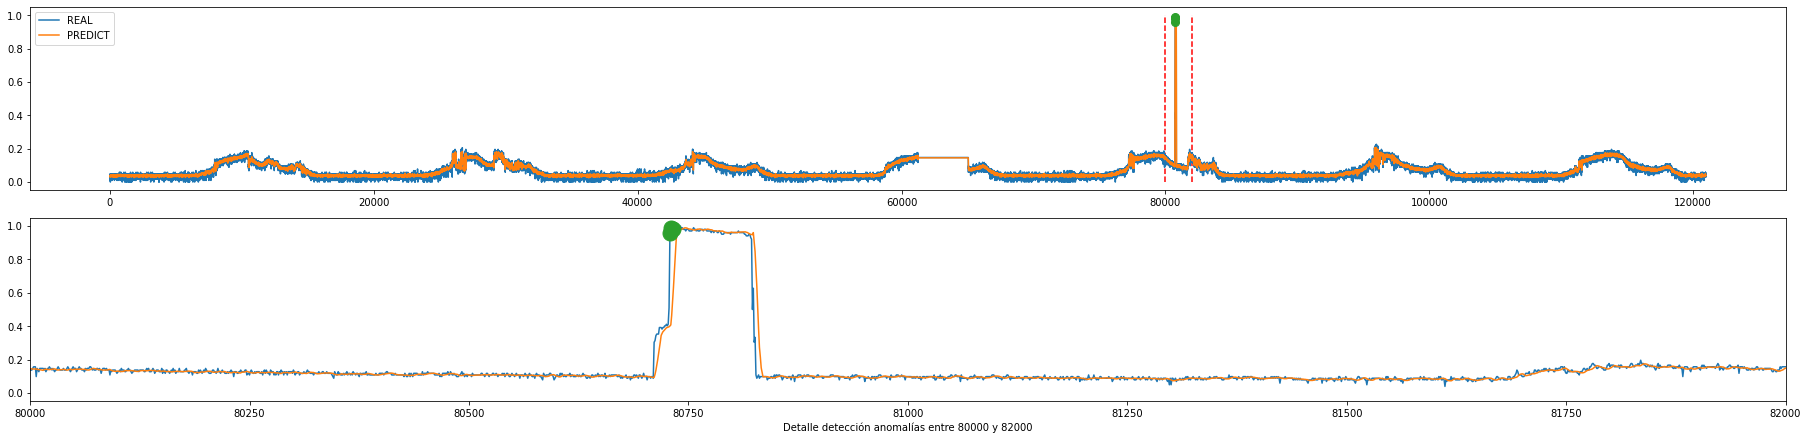

In [ ]:
plot_predict(df_predict_lite, 80000, 82000)

In [ ]:
testRoom = 29
ScCat= "ScHum"
threshold_2l = 0.15
path = '/content/drive/My Drive/UOC/TFM/MODELS/'
model = 'model_Hum_8.tf'

df_predict_lite = a_lite(testRoom, ScCat, threshold_2l, path, model)

La media de la diferencia es:2.197921276092529e-09
El tamaño del modelo con dataset representativo (modelo 3) es de 4816 bytes
El tamaño del modelo con optimización por defecto (modelo 2) es de 4352 bytes
El tamaño del modelo sin optimización (modelo 1) es de 4348 bytes
La diferencia entre modelo 2 y modelo 3 es de  -464 bytes


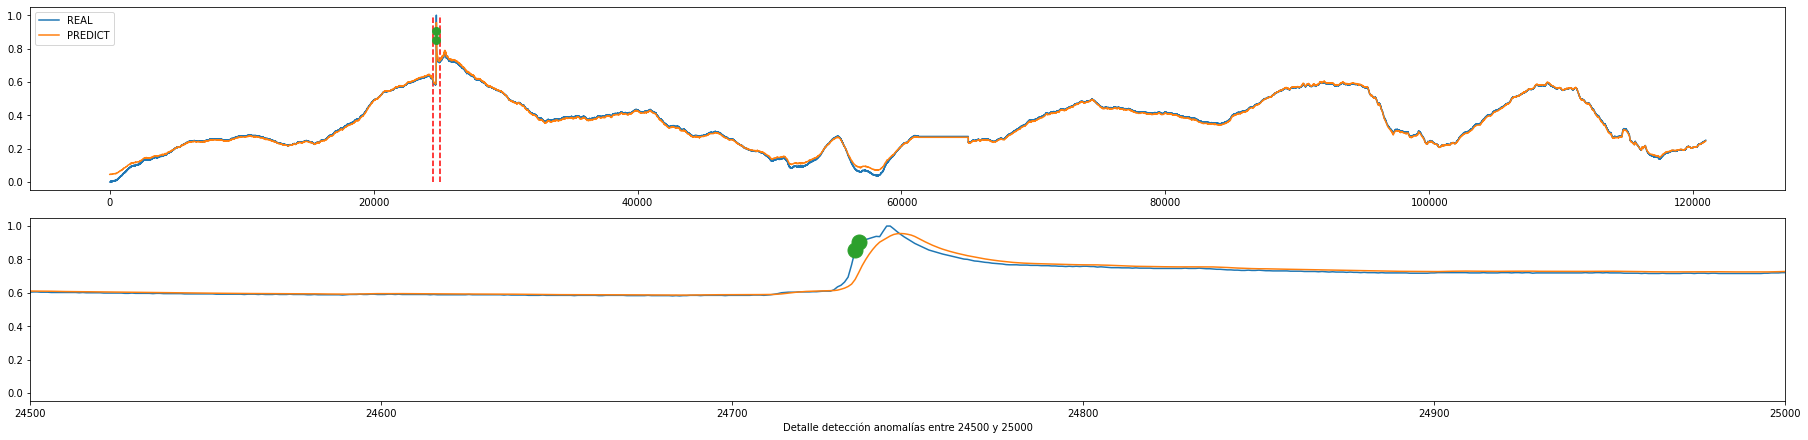

In [ ]:
plot_predict(df_predict_lite, 24500, 25000)

In [ ]:
# Install xxd if it is not available
# '/content/drive/MyDrive/UOC/TFM/MODELS/model_lite_ScHum_3.tflite'  
!apt-get -qq install xxd
# Save the file as a C source file
!xxd -i /content/drive/MyDrive/UOC/TFM/MODELS/model_lite_8_ScHum_3.tflite > /content/drive/MyDrive/UOC/TFM/MODELS/model_lite_8_ScHum_3.cc
# Print the source file
!cat /content/drive/MyDrive/UOC/TFM/MODELS/model_lite_8_ScHum_3.cc